In [1]:
import sys

sys.path.append("ml-tools-direct-method")
from pathlib import Path

In [2]:
from tools.bandit import generate_bandit_feedback
from tools.estimate import get_estimator_stats, get_value_estimators
from tools.policy import CorrelatedPolicy, ModelPolicy, UniformPolicy
from tools.utils import datasets, get_bandit, split_data

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import default_rng
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_palette("colorblind")
colors = sns.color_palette()
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["axes.titlesize"] = 14

X_MED = 10
Y_MED = 6
XY_MED = (X_MED, Y_MED)

In [3]:
SKIP_NONLIN = False
NUM_TRIALS = 500

## Experiments with Small Public Datasets 

In [4]:
frames = {}
for seed, data in enumerate(datasets):

    if data in [
        "satimage",
        "vehicle",
        # "pendigits",
    ]:  # skip these for now, I don't expect them to converge in a linear model.
        continue

    # configure dataset into bandit setting
    contexts, full_rewards, best_actions = get_bandit(data)
    n, k = full_rewards.shape
    _, d = contexts.shape
    print(
        f"This dataset has {k} actions, the context space has {d} dimensions, and there are {n} examples."
    )

    # split train test sets
    rng = default_rng(3)
    X_train, y_train, X_test, y_test, full_rewards_test = split_data(
        contexts, full_rewards, best_actions, rng
    )

    # create target policy using logreg
    print("Fitting target policy")
    model = LogisticRegression(multi_class="multinomial", max_iter=10000)
    model.fit(X_train, y_train)
    target_policy = ModelPolicy(model=model, num_actions=k)
    # get true value of target policy -> treated as ground truth for comparing estimates
    target_policy_true_value = target_policy.get_value_estimate(
        X_test, full_rewards_test
    )

    # create logging policy
    logging_policy = CorrelatedPolicy(
        num_actions=k, num_features=d, rng=default_rng(seed)
    )

    # run 500 simulations
    trials = NUM_TRIALS
    val_ests = []
    policy = target_policy
    policy_true_value = policy.get_value_estimate(X_test, full_rewards_test)
    rng = default_rng(6)
    print("Simulating...")
    for i in tqdm(range(trials)):
        contexts, actions, rewards, propensities = generate_bandit_feedback(
            X_test, full_rewards_test, logging_policy, rng=rng
        )
        est = get_value_estimators(
            policy,
            contexts,
            actions,
            rewards,
            propensities,
            skip_nonlin=SKIP_NONLIN,
            model_propensities=True,
        )
        val_ests.append(est)

    df = pd.DataFrame(val_ests)
    print(f"Target policy true value {target_policy_true_value}.")
    df_stats = get_estimator_stats(df, true_parameter_value=policy_true_value)
    df_stats["true"] = policy_true_value
    print(df_stats)

    frames[data] = df_stats

  0%|          | 0/500 [00:00<?, ?it/s]

Loaded ecoli from local csv
This dataset has 8 actions, the context space has 7 dimensions, and there are 336 examples.
Fitting target policy
Simulating...


100%|██████████| 500/500 [09:49<00:00,  1.18s/it]


Target policy true value 0.5528155516354565.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.529322  0.072845  0.005306  0.003258  0.023494  0.076540   
1         dm  0.495996  0.055673  0.003100  0.002490  0.056819  0.079548   
2      dm_iw  0.554741  0.053380  0.002849  0.002387  0.001926  0.053414   
3     dm_log  0.323176  0.053799  0.002894  0.002406  0.229640  0.235857   
4  dm_log_iw  0.546422  0.052861  0.002794  0.002364  0.006394  0.053246   
5         dr  0.544269  0.053538  0.002866  0.002394  0.008547  0.054216   
6     dr_log  0.533421  0.060414  0.003650  0.002702  0.019395  0.063451   
7      dm_rf  0.323050  0.137682  0.018956  0.006157  0.229765  0.267859   
8      dr_rf  0.500925  0.070457  0.004964  0.003151  0.051891  0.087503   

       true  
0  0.552816  
1  0.552816  
2  0.552816  
3  0.552816  
4  0.552816  
5  0.552816  
6  0.552816  
7  0.552816  
8  0.552816  
Loaded glass from local csv
This dataset has 6 actions

  0%|          | 0/500 [00:00<?, ?it/s]

Simulating...


100%|██████████| 500/500 [09:30<00:00,  1.14s/it]


Target policy true value 0.4614749348080331.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.407067  0.088898  0.007903  0.003976  0.054407  0.104226   
1         dm  0.402130  0.090915  0.008266  0.004066  0.059345  0.108570   
2      dm_iw  0.437826  0.109796  0.012055  0.004910  0.023649  0.112314   
3     dm_log  0.358473  0.068484  0.004690  0.003063  0.103002  0.123691   
4  dm_log_iw  0.423102  0.080827  0.006533  0.003615  0.038373  0.089474   
5         dr  0.428490  0.095172  0.009058  0.004256  0.032985  0.100726   
6     dr_log  0.414440  0.080293  0.006447  0.003591  0.047035  0.093055   
7      dm_rf  0.185709  0.130568  0.017048  0.005839  0.275766  0.305114   
8      dr_rf  0.387612  0.092525  0.008561  0.004138  0.073863  0.118392   

       true  
0  0.461475  
1  0.461475  
2  0.461475  
3  0.461475  
4  0.461475  
5  0.461475  
6  0.461475  
7  0.461475  
8  0.461475  
Loaded letter-recognition from local csv
This dataset 

  0%|          | 0/500 [00:00<?, ?it/s]

Simulating...


100%|██████████| 500/500 [1:34:51<00:00, 11.38s/it]


Target policy true value 0.642203645455189.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.642823  0.032604  0.001063  0.001458  0.000620  0.032610   
1         dm  0.217811  0.009297  0.000086  0.000416  0.424393  0.424494   
2      dm_iw  0.621844  0.016734  0.000280  0.000748  0.020360  0.026354   
3     dm_log  0.420507  0.013193  0.000174  0.000590  0.221697  0.222089   
4  dm_log_iw  0.601472  0.014843  0.000220  0.000664  0.040731  0.043352   
5         dr  0.625862  0.024238  0.000587  0.001084  0.016342  0.029233   
6     dr_log  0.600188  0.017603  0.000310  0.000787  0.042015  0.045554   
7      dm_rf  0.194156  0.024997  0.000625  0.001118  0.448047  0.448744   
8      dr_rf  0.485958  0.021861  0.000478  0.000978  0.156246  0.157768   

       true  
0  0.642204  
1  0.642204  
2  0.642204  
3  0.642204  
4  0.642204  
5  0.642204  
6  0.642204  
7  0.642204  
8  0.642204  
Loaded optdigits from local csv
This dataset has 10 act

  0%|          | 0/500 [00:00<?, ?it/s]

Simulating...


100%|██████████| 500/500 [57:45<00:00,  6.93s/it] 


Target policy true value 0.9554505815120042.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.948368  0.037167  0.001381  0.001662  0.007083  0.037836   
1         dm  0.684830  0.014598  0.000213  0.000653  0.270620  0.271014   
2      dm_iw  0.919351  0.021406  0.000458  0.000957  0.036100  0.041969   
3     dm_log  0.878771  0.010958  0.000120  0.000490  0.076679  0.077459   
4  dm_log_iw  0.956115  0.007824  0.000061  0.000350  0.000665  0.007852   
5         dr  0.910004  0.017433  0.000304  0.000780  0.045447  0.048676   
6     dr_log  0.885310  0.011179  0.000125  0.000500  0.070141  0.071026   
7      dm_rf  0.642659  0.026889  0.000723  0.001203  0.312792  0.313945   
8      dr_rf  0.735547  0.025561  0.000653  0.001143  0.219903  0.221384   

       true  
0  0.955451  
1  0.955451  
2  0.955451  
3  0.955451  
4  0.955451  
5  0.955451  
6  0.955451  
7  0.955451  
8  0.955451  
Loaded pendigits from local csv
This dataset has 10 ac

/Users/danturkel/.pyenv/versions/3.6.12/envs/ml-tools/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
  0%|          | 0/500 [00:00<?, ?it/s]

Simulating...


 10%|█         | 50/500 [04:57<45:43,  6.10s/it]/Users/danturkel/.pyenv/versions/3.6.12/envs/ml-tools/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 39%|███▉      | 194/500 [18:38<28:45,  5.64s/it]/Users/danturkel/.pyenv/versions/3.6.12/envs/ml-tools/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Target policy true value 0.9294766443508493.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.930373  0.027241  0.000742  0.001218  0.000896  0.027256   
1         dm  0.553871  0.011268  0.000127  0.000504  0.375606  0.375775   
2      dm_iw  0.931263  0.008423  0.000071  0.000377  0.001786  0.008611   
3     dm_log  0.855544  0.009394  0.000088  0.000420  0.073933  0.074527   
4  dm_log_iw  0.912974  0.008885  0.000079  0.000397  0.016503  0.018743   
5         dr  0.921530  0.015000  0.000225  0.000671  0.007946  0.016975   
6     dr_log  0.908697  0.010506  0.000110  0.000470  0.020779  0.023284   
7      dm_rf  0.796859  0.014254  0.000203  0.000637  0.132618  0.133382   
8      dr_rf  0.834894  0.013623  0.000186  0.000609  0.094583  0.095559   

       true  
0  0.929477  
1  0.929477  
2  0.929477  
3  0.929477  
4  0.929477  
5  0.929477  
6  0.929477  
7  0.929477  
8  0.929477  
Loaded yeast from local csv
This dataset has 10 action

100%|██████████| 500/500 [13:06<00:00,  1.57s/it]

Target policy true value 0.3314289525705208.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.325232  0.032274  0.001042  0.001443  0.006197  0.032863   
1         dm  0.297344  0.030158  0.000910  0.001349  0.034085  0.045512   
2      dm_iw  0.333582  0.029604  0.000876  0.001324  0.002153  0.029682   
3     dm_log  0.237489  0.025523  0.000651  0.001141  0.093940  0.097345   
4  dm_log_iw  0.329677  0.029409  0.000865  0.001315  0.001752  0.029461   
5         dr  0.331470  0.029709  0.000883  0.001329  0.000041  0.029709   
6     dr_log  0.328286  0.030420  0.000925  0.001360  0.003143  0.030582   
7      dm_rf  0.121294  0.049481  0.002448  0.002213  0.210135  0.215882   
8      dr_rf  0.267442  0.031945  0.001020  0.001429  0.063987  0.071518   

       true  
0  0.331429  
1  0.331429  
2  0.331429  
3  0.331429  
4  0.331429  
5  0.331429  
6  0.331429  
7  0.331429  
8  0.331429  


In [5]:
#save estimator dfs for each dataset (so we don't need to re-run)
if not Path("results").exists():
    Path("results").mkdir()
for frame in frames:
    frames[frame].to_csv(f"results/{frame}_results.csv")
    print(f"Saved {frame} results")

Saved ecoli results
Saved glass results
Saved letter-recognition results
Saved optdigits results
Saved pendigits results
Saved yeast results


In [6]:
#only load in datasets used
datasets = ['ecoli','glass','letter-recognition','optdigits','yeast','pendigits']

frames = {}
for data in datasets:
    frames[data] = pd.read_csv(f"results/{data}_results.csv")
    print(f"Loaded saved results for {data}")

Loaded saved results for ecoli
Loaded saved results for glass
Loaded saved results for letter-recognition
Loaded saved results for optdigits
Loaded saved results for yeast
Loaded saved results for pendigits


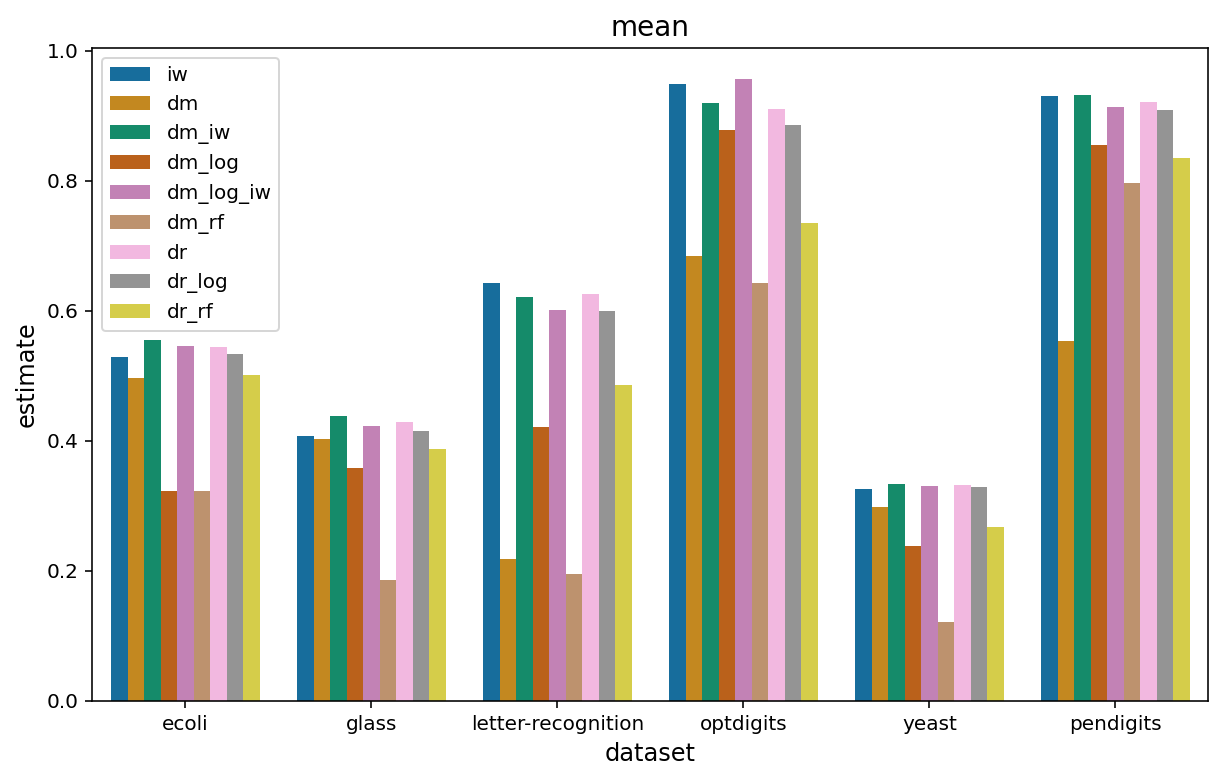

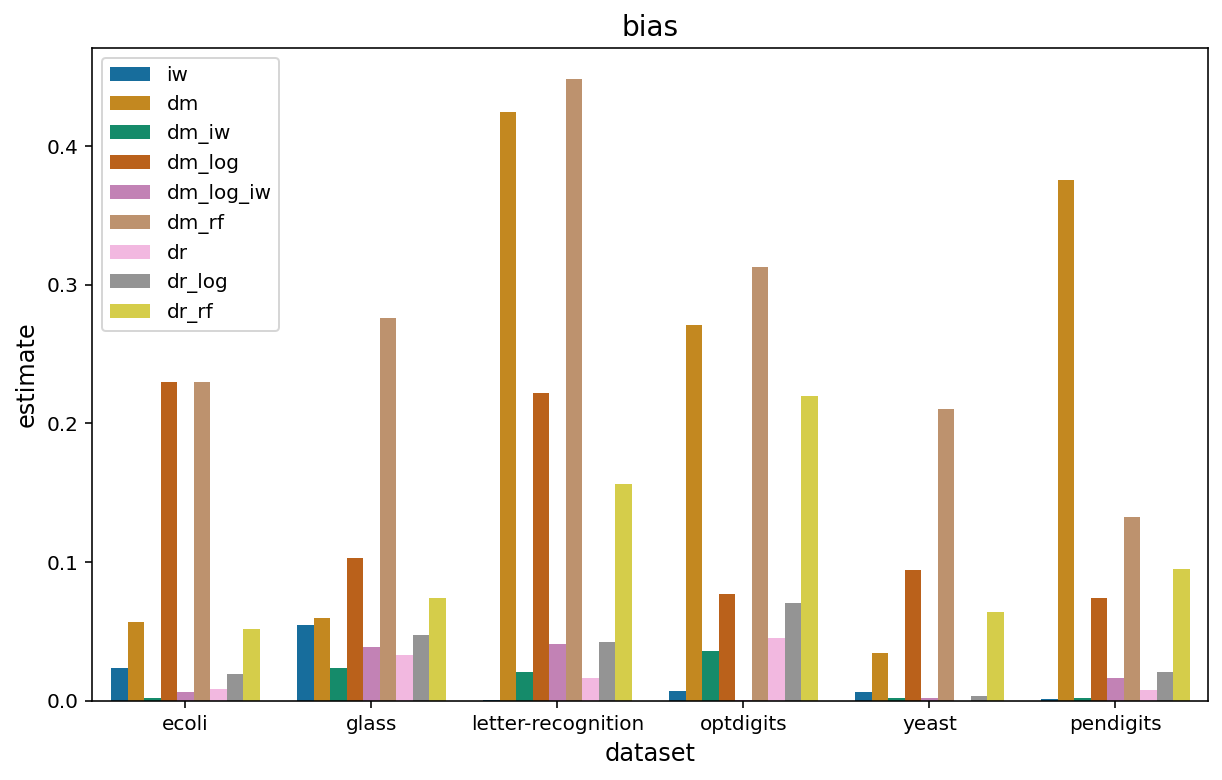

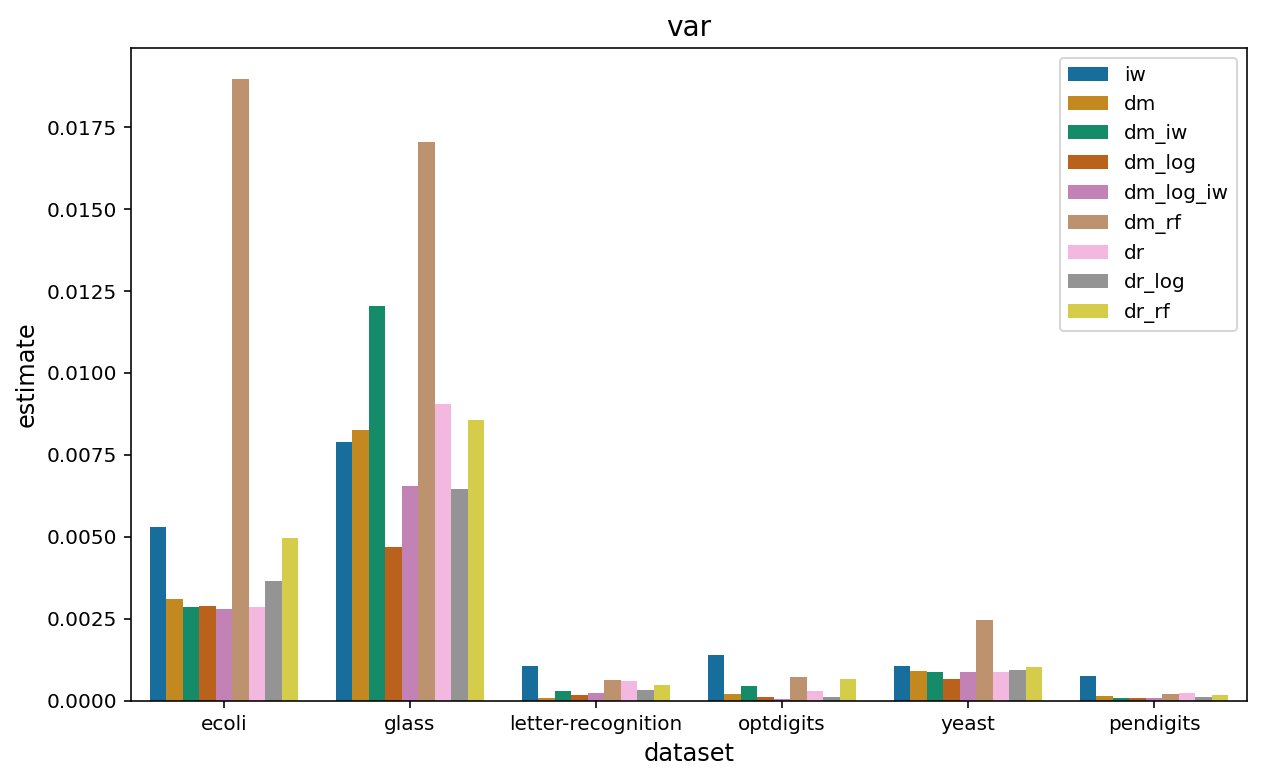

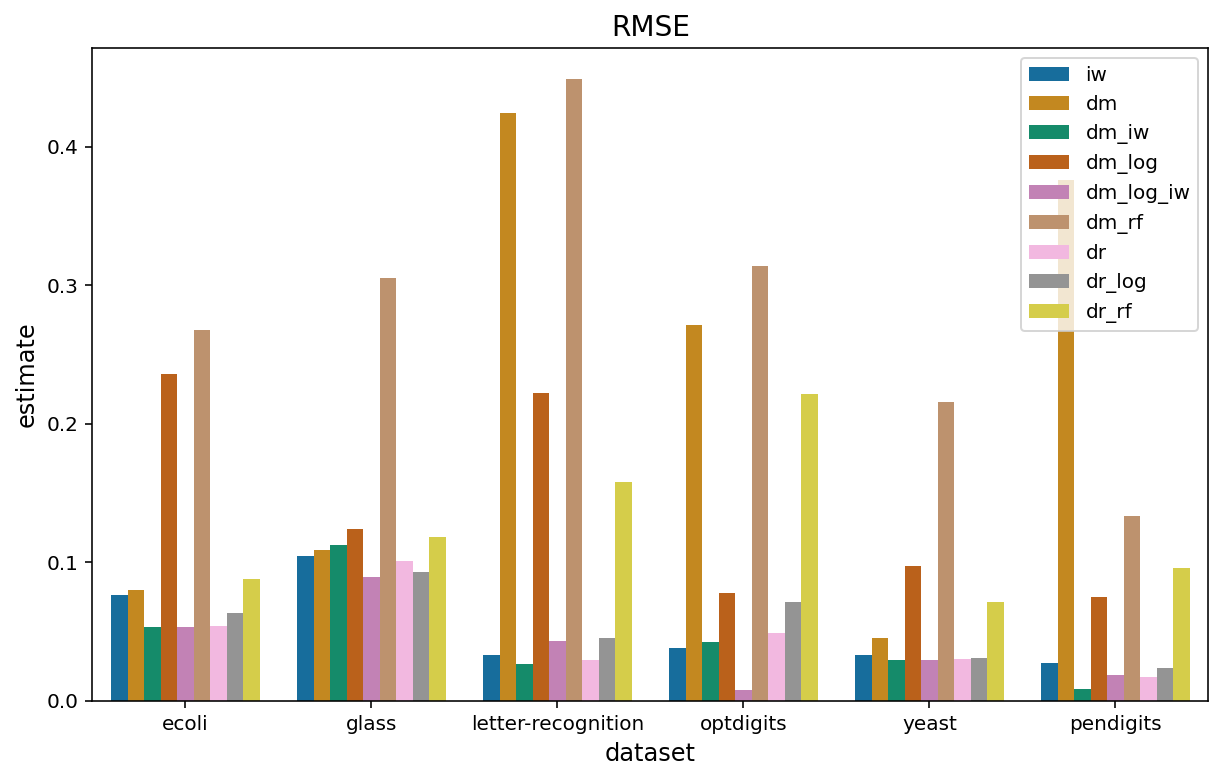

In [7]:
# visualize estimator stats for each dataset

stats = ["mean", "bias", "var", "RMSE"]
skip_nonlin = SKIP_NONLIN
for stat in stats:
    iw = []
    dm = []
    dm_iw = []
    dm_log = []
    dm_log_iw = []
    dr = []
    dr_log = []
    dm_rf = []
    dr_rf = []
    for data in datasets:

        iw.append(abs(frames[data][stat][0]))
        dm.append(abs(frames[data][stat][1]))
        dm_iw.append(abs(frames[data][stat][2]))
        dm_log.append(abs(frames[data][stat][3]))
        dm_log_iw.append(abs(frames[data][stat][4]))
        dr.append(abs(frames[data][stat][5]))
        dr_log.append(abs(frames[data][stat][6]))

        if not skip_nonlin:
            dm_rf.append(abs(frames[data][stat][7]))
            dr_rf.append(abs(frames[data][stat][8]))

    if skip_nonlin:
        df = pd.DataFrame(
            np.c_[iw, dm, dm_iw, dm_log, dm_log_iw, dr, dr_log],
            index=datasets,
            columns=["iw", "dm", "dm_iw", "dm_log", "dm_log_iw", "dr", "dr_log"],
        )
        df = (
            df.reset_index()
            .rename({"index": "dataset"}, axis=1)
            .melt(id_vars=["dataset"], var_name="estimator", value_name="estimate")
        )
    else:
        df = pd.DataFrame(
            np.c_[iw, dm, dm_iw, dm_log, dm_log_iw, dm_rf, dr, dr_log, dr_rf],
            index=datasets,
            columns=[
                "iw",
                "dm",
                "dm_iw",
                "dm_log",
                "dm_log_iw",
                "dm_rf",
                "dr",
                "dr_log",
                "dr_rf",
            ],
        )
        df = (
            df.reset_index()
            .rename({"index": "dataset"}, axis=1)
            .melt(id_vars=["dataset"], var_name="estimator", value_name="estimate")
        )

    fig, ax = plt.subplots(figsize=XY_MED)
    sns.barplot(data=df, x="dataset", y="estimate", hue="estimator", ax=ax)
    ax.legend()
    ax.set_title(stat)
    ax.tick_params(axis="x", labelrotation=0)

In [8]:
ls

LICENSE                             proof of concept.ipynb
README.md                           requirements.txt
data/                               results/
proof of concept adversarial.ipynb  tools/
